In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Part 1: Preprocessing and Visualization**

In [2]:
csv_file = "Reviews.csv"
df = pd.read_csv(csv_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
df.drop(columns=df.columns.difference(['Score', 'Text']), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   568454 non-null  int64 
 1   Text    568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


The first feature to be examined is the Score. We can see that most reviews accompany highly scored products. This is hinting at the fact that most reviews will carry a positive sentiment.

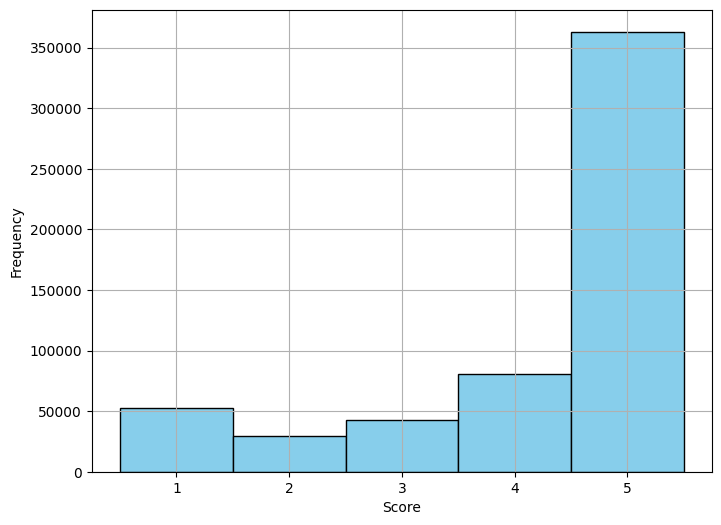

4.183198640523243


In [4]:
# Plot the distribution of 'Score'
plt.figure(figsize=(8, 6))
plt.hist(df['Score'], bins=[0.5,1.5,2.5,3.5,4.5,5.5], color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print(df['Score'].mean())

The text data is preprocessed through cleaning, conversion to lowercase, stopword removal, and lemmatization.

In [5]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Drop the duplicates based on 'Review' and 'Sentiment' columns
duplicate_count = df.duplicated().sum()
print("Number of duplicates:", duplicate_count)
df.drop_duplicates(inplace=True)

# Load NLTK resources if not already downloaded
if not nltk.download("punkt", quiet=True):
    nltk.download("punkt")
if not nltk.download("stopwords", quiet=True):
    nltk.download("stopwords")
if not nltk.download("wordnet", quiet=True):
    nltk.download("wordnet")

#Text Preprocessing
english_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML symbols
    text=re.sub(r'<.*?>', ' ', text)
    # Convert to lower
    text=text.lower()
    # Remove non alphabetic symbols
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\d+', ' ', text) 
    text = re.sub(r'\s+', ' ', text)
    # Tokenize sentences
    tokens = word_tokenize(text)
    # Lemmatize words and remove stopwords
    text=" ".join([lemmatizer.lemmatize(word) for word in tokens if not word  in english_stopwords])

    return text

# Apply preprocessing to the Review column
df['Preprocessed'] = df['Text'].apply(preprocess_text)

Number of duplicates: 174779


The reviews are put through an unsupervised model for classification, and as expected, the obtained review sentiments are overwhelmingly positive.

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each row in the DataFrame
df['Sentiment'] = df['Preprocessed'].apply(lambda x: sid.polarity_scores(x))

# Convert sentiment scores to categorical labels
df['Sentiment'] = df['Sentiment'].apply(lambda scores: 1 if scores['compound'] > 0 else 0 if scores['compound'] < 0 else None)

df['Sentiment'].value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment
1.0    360228
0.0     27931
Name: count, dtype: int64

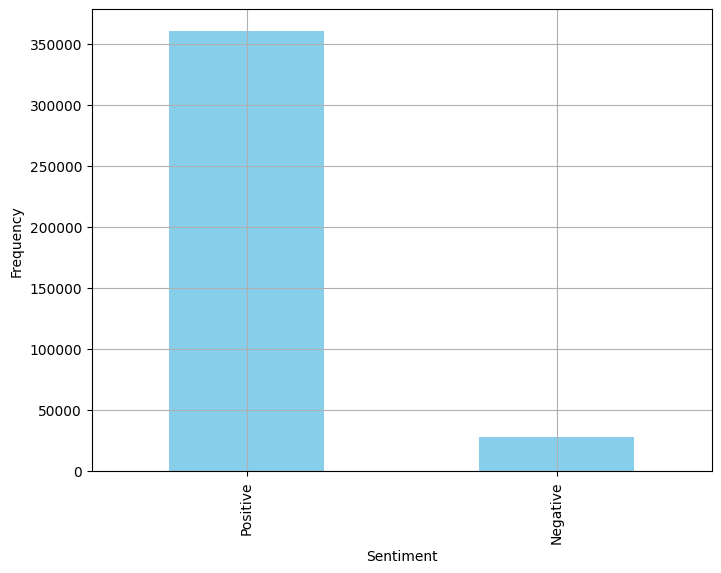

In [7]:
# Plot the distribution of sentiment categories
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Positive', 'Negative'])
plt.grid(True)
plt.show()

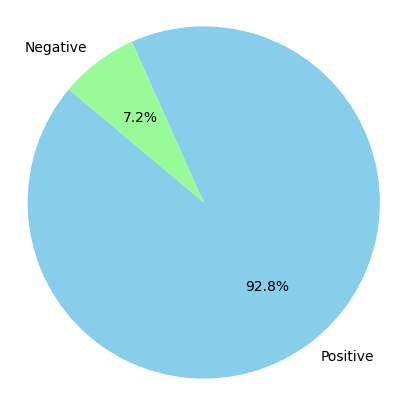

In [8]:
# Count the frequency of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', colors=['skyblue', 'palegreen'], startangle=140)
plt.axis('equal')
plt.show()

The next feature to be examined is the Review itself which is also known as Text and was preprocessed as placed in a new column called Preprocessed.

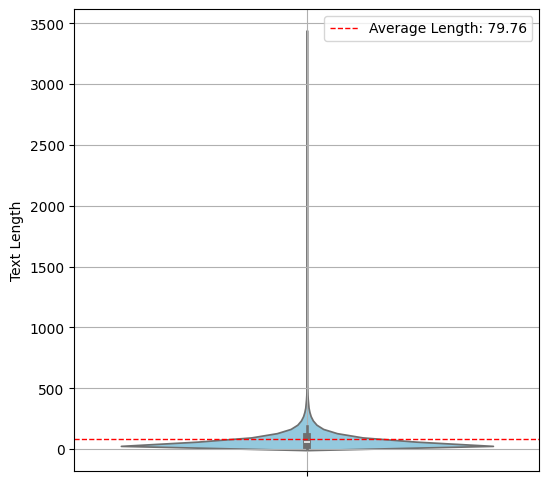

In [9]:
# Draw a violin plot portraying the distribution of text lengths
df['Text_length']  = df['Text'].apply(lambda x: len(str(x).split()))
average_length = df['Text_length'].mean()

plt.figure(figsize=(6, 6))
sns.violinplot(y=df['Text_length'], color='skyblue')
plt.axhline(average_length, color='red', linestyle='dashed', linewidth=1, label=f'Average Length: {average_length:.2f}')
plt.ylabel('Text Length')
plt.legend()
plt.grid(True)
plt.show()

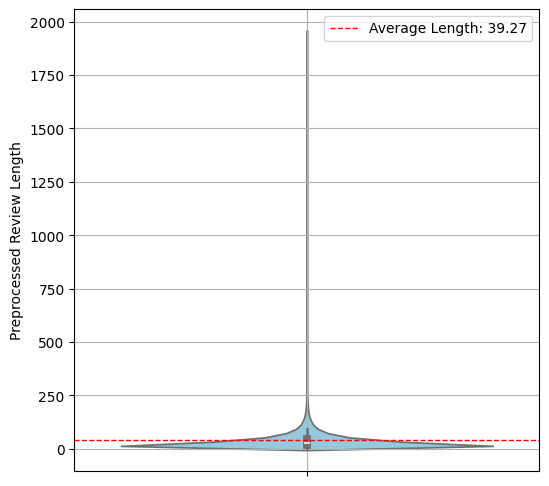

In [10]:
# Draw a violin plot portraying the distribution of preprocessed review lengths
df['Preprocessed_review_length']  = df['Preprocessed'].apply(lambda x: len(str(x).split()))
average_length = df['Preprocessed_review_length'].mean()

plt.figure(figsize=(6, 6))
sns.violinplot(y=df['Preprocessed_review_length'], color='skyblue')
plt.axhline(average_length, color='red', linestyle='dashed', linewidth=1, label=f'Average Length: {average_length:.2f}')
plt.ylabel('Preprocessed Review Length')
plt.legend()
plt.grid(True)
plt.show()

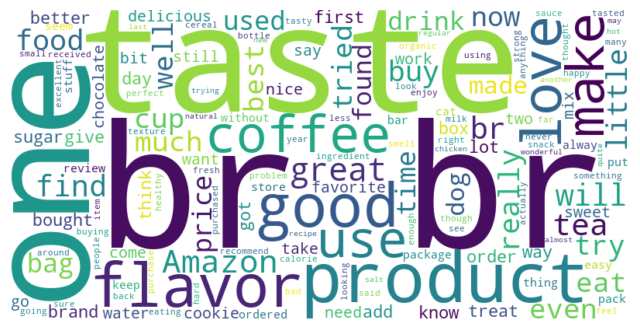

In [11]:
from wordcloud import WordCloud
import random

# Sample a some of the text data to be used in a word cloud
sample_size = 10000 
sampled_text = random.sample(df['Text'].dropna().tolist(), min(sample_size, len(df)))

# Combine the sampled text into a single string
sampled_text_combined = ' '.join(sampled_text)

# Generate a word cloud with a frequency threshold
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(sampled_text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

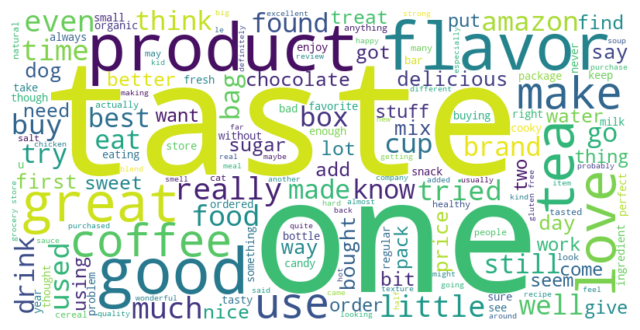

In [12]:
# Sample a subset of the preprocessed review data to be used in a word cloud
sampled_reviews = random.sample(df['Preprocessed'].dropna().tolist(), min(sample_size, len(df)))

# Combine the sampled reviews into a single string
sampled_reviews_combined = ' '.join(sampled_reviews)

# Generate a word cloud with a frequency threshold
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(sampled_reviews_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

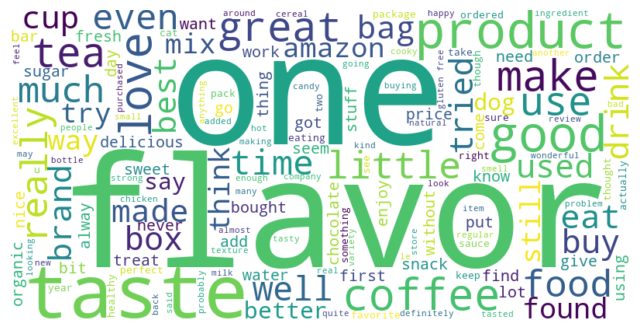

In [13]:
# Sample a subset of the text data with positive sentiment directly
sample_size = 10000 
sampled_text = random.sample(df[df['Sentiment'] == 1]['Preprocessed'].dropna().tolist(), min(sample_size, len(df)))

# Combine the sampled text into a single string
sampled_text_combined = ' '.join(sampled_text)

# Generate a word cloud with a frequency threshold
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(sampled_text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

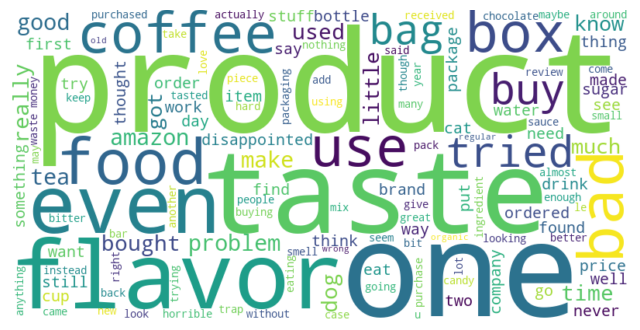

In [14]:
# Sample a subset of the text data with positive sentiment directly
sample_size = 10000 
sampled_text = random.sample(df[df['Sentiment'] == 0]['Preprocessed'].dropna().tolist(), min(sample_size, len(df)))

# Combine the sampled text into a single string
sampled_text_combined = ' '.join(sampled_text)

# Generate a word cloud with a frequency threshold
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(sampled_text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
df.head()

,Score,Text,Preprocessed,Sentiment,Text_length,Preprocessed_review_length
0,5,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,1.0,48,23
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,0.0,31,18
2,4,This is a confection that has been around a fe...,confection around century light pillowy citrus...,1.0,94,40
3,2,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1.0,41,18
4,5,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,1.0,27,13


### **Part 2: Sampling and Train-Test Split**

To balance the dataset, we take 50k elements of each type (Postive and Negative).

In [16]:
np.random.seed(21)

# Filter the DataFrame to include only rows where 'Sentiment' column equals 0 or 1
data_score_1 = df[df['Sentiment'] == 1].reset_index(drop=True)
data_score_0 = df[df['Sentiment'] == 0].reset_index(drop=True)

# Generate random indices
random_indices_1 = np.random.choice(len(data_score_1), 10000, replace=False)
random_indices_0 = np.random.choice(len(data_score_0), 10000, replace=False)

# Concatenate and reset index
sampled_data = pd.concat([data_score_1.iloc[random_indices_1], data_score_0.iloc[random_indices_0]], axis=0).reset_index(drop=True)

Vectorization is used to transform textual data into a more appropriate format for training models.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Vectorize the data
vect = CountVectorizer()
X = vect.fit_transform(sampled_data['Preprocessed'])

tfidf = TfidfTransformer()
X_vec = tfidf.fit_transform(X)

In [18]:
# Get the words with the lowest TF-IDF score
feature_names = vect.get_feature_names_out()
idf_scores = tfidf.idf_
word_scores = dict(zip(feature_names, idf_scores))
sorted_word_scores = sorted(word_scores.items(), key=lambda x: x[1])

# Print words
num_words_to_print = 10
print("Words with the least TF-IDF scores:")
for word, score in sorted_word_scores[:num_words_to_print]:
    print(f"{word}: {score}")

Words with the least TF-IDF scores:
like: 2.3201821576162636
taste: 2.343668085589496
product: 2.3996322541968675
one: 2.4300872828178512
good: 2.593860655298443
flavor: 2.687719759453716
would: 2.717630069803845
get: 2.8091591063132095
great: 2.9146552979769424
time: 2.943912246188055


Tokenization, or breaking down the text into words, is key in NLP, and it is required in deep learning models such as LSTM. Here, a tokenizer extracts the word dictionary from the training data.

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sampled_data['Preprocessed'])

sequences = tokenizer.texts_to_sequences(sampled_data['Preprocessed'])
x_padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


24846


Perform a train test split on the data. The same random state is used to maintain the same data split among all of our models.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, sampled_data['Sentiment'], test_size=0.2,random_state=42)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_padded, sampled_data['Sentiment'], test_size=0.2,random_state=42)

### **Part 3: Classification Algorithms**

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


### **Machine Learning Algorithms**

Logistic Regression:

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
# Define parameters for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 2,5],
    'penalty': ['l1', 'l2'],  
    'solver': ['saga', 'liblinear']    
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

# Perform grid search
grid_search_log = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
grid_search_log.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.3s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=5, penalty=l1, solver=saga; total time= 1.1min


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=5, penalty=l1, solver=saga; total time= 1.2min


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=5, penalty=l1, solver=saga; total time= 1.1min


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=5, penalty=l1, solver=saga; total time= 1.1min
[CV] END ..................C=5, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=5, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..................C=5, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=5, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=5, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .......................C=5, penalty=l2, solver=saga; total time=   0.2s
[CV] END .......................C=5, penalty=l2, solver=saga; total time=   0.2s
[CV] END .......................C=5, penalty=l2, solver=saga; total time=   0.2s
[CV] END .......................C=5, penalty=l2, solver=saga; total time=   0.2s
[CV] END .......................C=5, penalty=l2, solver=saga; total time=   0.2s
[CV] END ..................C=5, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 2, 5], 'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=2)

In [23]:
predictedLog=grid_search_log.best_estimator_.predict(X_test)
print(np.array(grid_search_log.best_params_))
print(grid_search_log.best_score_)

{'C': 2, 'penalty': 'l1', 'solver': 'saga'}
0.9170625000000001


In [26]:
from sklearn.metrics import classification_report
# Evaluation of the Logistic Regression model
print("Classification Report")
print(f"{classification_report(y_test, predictedLog )}")
# Evaluation of the Logistic Regression model
print(f"Accuracy: {accuracy_score(y_test, predictedLog)}")
print(f"Precision: {precision_score(y_test, predictedLog, average='macro')}")
print(f"Recall: {recall_score(y_test, predictedLog, average='macro')}")
print(f"F1 Score: {f1_score(y_test, predictedLog, average='macro')}")

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1981
         1.0       0.94      0.90      0.92      2019

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

Accuracy: 0.9205
Precision: 0.9213450285808433
Recall: 0.9207255954849926
F1 Score: 0.9204821084744067


In [31]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, predictedLog)
confusion_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
confusion_df

,Predicted 0,Predicted 1
Actual 0,1871,110
Actual 1,208,1811


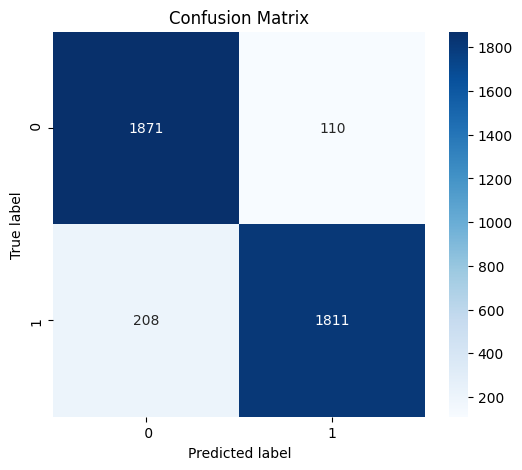

In [36]:
# Generate confusion matrix
cm = confusion_df

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[' 0', '1'], yticklabels=[' 0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Random Forest:

We utilized grid search to fine-tune the optimal number of estimators required for achieving peak performance. Notably, this process was executed on the HPC server for AUB due to the significant computational time involved. Following our analysis, we established that the optimal number of estimators is 400. Beyond this threshold, the performance stabilizes, consistent with the inherent characteristics of the random forest algorithm. Subsequently, we applied the random forest algorithm using the determined optimal number of estimators to obtain the necessary information.

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Define parameters for grid search
model1=RandomForestClassifier()
param_grid1 = {
    # Also tried 200, 300, 350
     'n_estimators': [400,450,500,550,600]
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

# Perform grid search
# We applied this in the HPC server.
# Here we only applied the Random forest algorithm at the best hyperparameter (n_estimators=500)
clf_randomForest = RandomForestClassifier(n_estimators=500)
clf_randomForest.fit(X_train, y_train)

In [40]:
predictedRF = clf_randomForest.predict(X_test)
# Evaluation of the Random Forest model
print("Classification Report")
print(f"{classification_report(y_test,predictedRF )}")
# Evaluation of the Random Forest model
print(f"Accuracy: {accuracy_score(y_test, predictedRF)}")
print(f"Precision: {precision_score(y_test, predictedRF, average='macro')}")
print(f"Recall: {recall_score(y_test, predictedRF, average='macro')}")
print(f"F1 Score: {f1_score(y_test, predictedRF, average='macro')}")

Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1981
         1.0       0.88      0.88      0.88      2019

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

Accuracy: 0.88075
Precision: 0.8807380897852726
Recall: 0.8807416119304767
F1 Score: 0.8807397957987779


In [41]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, predictedRF)
confusion_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
confusion_df

,Predicted 0,Predicted 1
Actual 0,1743,238
Actual 1,239,1780


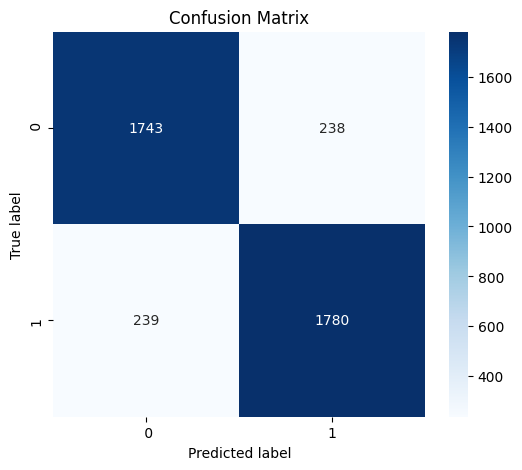

In [42]:
# Generate confusion matrix
cm = confusion_df

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[' 0', '1'], yticklabels=[' 0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

SVM:

In [43]:
from sklearn.svm import SVC

# Define parameters for grid search
model2=SVC()
param_grid2 = {
    'C': [0.1,1,2,5],
    'kernel': ['linear', 'rbf','poly']
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

# Perform grid search
grid_search_SVM = GridSearchCV(estimator=model2, param_grid=param_grid2, scoring='accuracy', cv=5, verbose=2)
grid_search_SVM.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  48.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  46.1s
[CV] END ...............................C=0.1, kernel=linear; total time=  46.5s
[CV] END ...............................C=0.1, kernel=linear; total time=  46.6s
[CV] END ...............................C=0.1, kernel=linear; total time=  46.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  59.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  59.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  59.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=  59.1s
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.4min
[CV] END .................................C=0.1, kernel=poly; total time=  59.8s
[CV] END .................................C=0.1,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 2, 5],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [44]:
predictedLinearSVC=grid_search_SVM.best_estimator_.predict(X_test)
print(np.array(grid_search_SVM.best_params_))
print(grid_search_SVM.best_score_)

{'C': 2, 'kernel': 'linear'}
0.9094374999999999


In [45]:
# Evaluation of the SVM model
print("Classification Report")
print(f"{classification_report(y_test,predictedLinearSVC )}")
# Evaluation of the SVM model
print(f"Accuracy: {accuracy_score(y_test, predictedLinearSVC)}")
print(f"Precision: {precision_score(y_test, predictedLinearSVC, average='macro')}")
print(f"Recall: {recall_score(y_test, predictedLinearSVC, average='macro')}")
print(f"F1 Score: {f1_score(y_test, predictedLinearSVC, average='macro')}")

Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1981
         1.0       0.93      0.88      0.91      2019

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

Accuracy: 0.90875
Precision: 0.9096721616932268
Recall: 0.9089864110235948
F1 Score: 0.9087258979324229


In [46]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, predictedLinearSVC)
confusion_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
confusion_df

,Predicted 0,Predicted 1
Actual 0,1850,131
Actual 1,234,1785


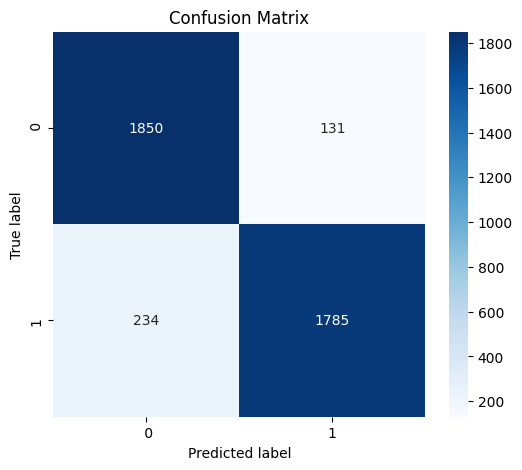

In [48]:
# Generate confusion matrix
cm = confusion_df

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[' 0', '1'], yticklabels=[' 0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### **Deep Learning**

Long Short Term Memory (LSTM)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,Embedding,Dense,Dropout,LSTM
from tensorflow.keras.metrics import Precision, Recall

As shown below, 75% of the preprocessed reviews are of length 46. 

In [50]:
sampled_data['Preprocessed_review_length'].describe()

count    20000.000000
mean        37.552050
std         34.676889
min          4.000000
25%         17.000000
50%         27.000000
75%         46.000000
max        709.000000
Name: Preprocessed_review_length, dtype: float64

Deep learning architechture:

In [80]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=46))
model.add(Bidirectional(LSTM(units=60,return_sequences=False)))
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

Fit the model to the training data and evaluate its performance using the following metrics:

- Accuracy

- Precision

- Recall


In [81]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Precision(),Recall()])
history=model.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),batch_size=64,epochs=2,verbose=1)

Epoch 1/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.7025 - loss: 0.5275 - precision_15: 0.7604 - recall_15: 0.5338 - val_accuracy: 0.8940 - val_loss: 0.2884 - val_precision_15: 0.8904 - val_recall_15: 0.9009
Epoch 2/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9438 - loss: 0.1635 - precision_15: 0.9485 - recall_15: 0.9377 - val_accuracy: 0.8995 - val_loss: 0.2591 - val_precision_15: 0.9040 - val_recall_15: 0.8960


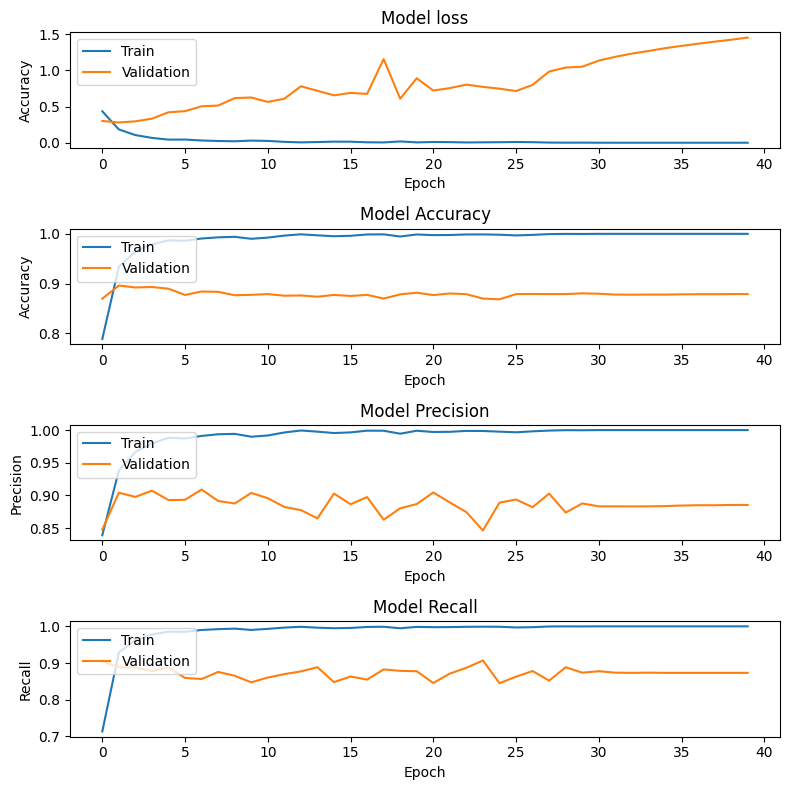

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(4, 1, 1)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(4, 1, 2)  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(4, 1, 3)  
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(4, 1, 4)  
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()  
plt.show()

In [82]:
y_pred=model.predict(X_test_lstm)
predictedLstm=np.where(y_pred >= 0.5, 1, 0)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [83]:
# Evaluation of the LSTM model
print("Classification Report")
print(f"{classification_report(y_test,predictedLstm )}")
# Evaluation of the LSTM model
print(f"Accuracy: {accuracy_score(y_test, predictedLstm)}")
print(f"Precision: {precision_score(y_test, predictedLstm, average='macro')}")
print(f"Recall: {recall_score(y_test, predictedLstm, average='macro')}")
print(f"F1 Score: {f1_score(y_test, predictedLstm, average='macro')}")

Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      1981
         1.0       0.90      0.90      0.90      2019

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

Accuracy: 0.8995
Precision: 0.8994977248744312
Recall: 0.899533682914883
F1 Score: 0.8994974874371859


In [84]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, predictedLstm)
confusion_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
confusion_df

,Predicted 0,Predicted 1
Actual 0,1789,192
Actual 1,210,1809


<function matplotlib.pyplot.show(close=None, block=None)>

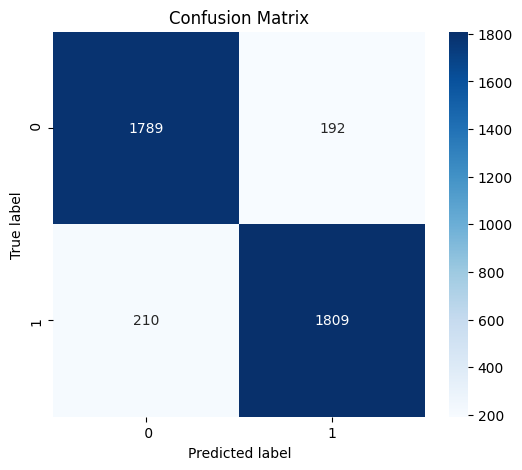

In [86]:
# Generate confusion matrix
cm = confusion_df

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[' 0', '1'], yticklabels=[' 0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show